## Trial of Time Series Analysis by Tensorflow Probability - Generalized Additive Model
#### Based on https://bayesiancomputationbook.com/markdown/chp_06.html#design-matrices-for-time-series and https://bayesiancomputationbook.com/markdown/chp_06.html#basis-functions-and-generalized-additive-model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

### Design Matrices for Time Series

In [2]:
n_changepoints = 8

In [3]:
n_tp = 500

In [4]:
t = np.linspace(0, 1, n_tp)

In [5]:
t

array([0.        , 0.00200401, 0.00400802, 0.00601202, 0.00801603,
       0.01002004, 0.01202405, 0.01402806, 0.01603206, 0.01803607,
       0.02004008, 0.02204409, 0.0240481 , 0.0260521 , 0.02805611,
       0.03006012, 0.03206413, 0.03406814, 0.03607214, 0.03807615,
       0.04008016, 0.04208417, 0.04408818, 0.04609218, 0.04809619,
       0.0501002 , 0.05210421, 0.05410822, 0.05611222, 0.05811623,
       0.06012024, 0.06212425, 0.06412826, 0.06613226, 0.06813627,
       0.07014028, 0.07214429, 0.0741483 , 0.0761523 , 0.07815631,
       0.08016032, 0.08216433, 0.08416834, 0.08617234, 0.08817635,
       0.09018036, 0.09218437, 0.09418838, 0.09619238, 0.09819639,
       0.1002004 , 0.10220441, 0.10420842, 0.10621242, 0.10821643,
       0.11022044, 0.11222445, 0.11422846, 0.11623246, 0.11823647,
       0.12024048, 0.12224449, 0.1242485 , 0.12625251, 0.12825651,
       0.13026052, 0.13226453, 0.13426854, 0.13627255, 0.13827655,
       0.14028056, 0.14228457, 0.14428858, 0.14629259, 0.14829

In [6]:
s = np.linspace(0, 1, n_changepoints + 2)[1:-1]

In [7]:
s

array([0.11111111, 0.22222222, 0.33333333, 0.44444444, 0.55555556,
       0.66666667, 0.77777778, 0.88888889])

In [8]:
matrix_a = (t[:, None] > s)

In [9]:
matrix_a

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [10]:
t[:, None]

array([[0.        ],
       [0.00200401],
       [0.00400802],
       [0.00601202],
       [0.00801603],
       [0.01002004],
       [0.01202405],
       [0.01402806],
       [0.01603206],
       [0.01803607],
       [0.02004008],
       [0.02204409],
       [0.0240481 ],
       [0.0260521 ],
       [0.02805611],
       [0.03006012],
       [0.03206413],
       [0.03406814],
       [0.03607214],
       [0.03807615],
       [0.04008016],
       [0.04208417],
       [0.04408818],
       [0.04609218],
       [0.04809619],
       [0.0501002 ],
       [0.05210421],
       [0.05410822],
       [0.05611222],
       [0.05811623],
       [0.06012024],
       [0.06212425],
       [0.06412826],
       [0.06613226],
       [0.06813627],
       [0.07014028],
       [0.07214429],
       [0.0741483 ],
       [0.0761523 ],
       [0.07815631],
       [0.08016032],
       [0.08216433],
       [0.08416834],
       [0.08617234],
       [0.08817635],
       [0.09018036],
       [0.09218437],
       [0.094

In [11]:
k, m = 2.5, 40

In [12]:
delta = np.random.laplace(.1, size=n_changepoints)

In [13]:
delta

array([-1.63191972,  0.21459728, -2.11933686,  0.52571378, -1.16356567,
        1.78644942,  0.05686485, -1.7933006 ])

In [14]:
(matrix_a @ delta).shape

(500,)

In [15]:
growth = (k + matrix_a @ delta) * t

In [16]:
-s * delta

array([ 0.18132441, -0.04768828,  0.70644562, -0.23365057,  0.64642537,
       -1.19096628, -0.04422822,  1.59404498])

In [17]:
offset = m + matrix_a @ (-s * delta)

In [18]:
trend = growth + offset

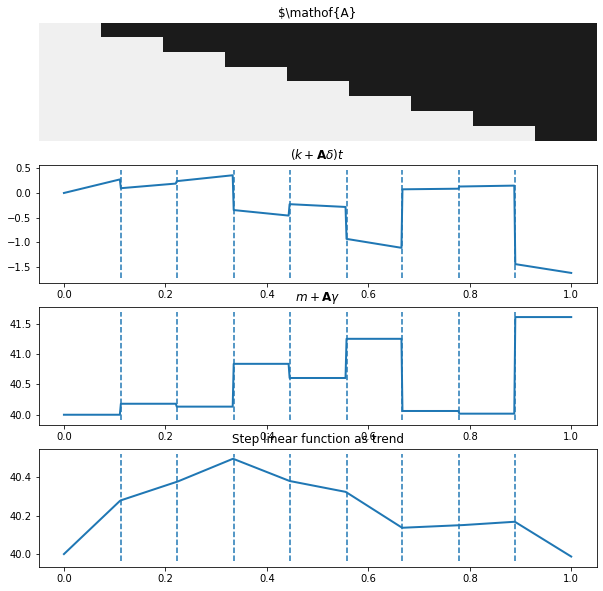

In [19]:
_, ax = plt.subplots(4, 1, figsize=(10, 10))
ax[0].imshow(matrix_a.T, cmap='cet_gray_r', aspect='auto', interpolation='none')
ax[0].axis('off')
ax[0].set_title(r'$\mathof{A}')
ax[1].plot(t, growth, lw=2)
ax[1].set_title(r'$(k + \mathbf{A}\delta) t$')
ax[2].plot(t, offset, lw=2)
ax[2].set_title(r'$m + \mathbf{A} \gamma$')
ax[3].plot(t, trend, lw=2)
ax[3].set_title('Step linear function as trend')

lines = [np.where(t > s_)[0][0] for s_ in s] 
for ax_ in ax[1:]:
    ax_.vlines(t[lines], *ax_.get_ylim(), linestyles='--')

plt.savefig("../plots/step_linear_function.png")

In [20]:
np.where(t > 0.11111111)[0][0]

56

### Basis Functions and Generalized Additive Model

In [21]:
# %load 'fourier_basis_function.py'
def gen_fourier_basis(t, p=365.25, n=3):
    x = 2 * np.pi * (np.arange(n) + 1) * t[:, None] / p 
    return np.concatenate((np.cos(x), np.sin(x)), axis=1)

In [22]:
n_tp = 500

In [23]:
p = 12

In [24]:
t_monthly = np.asarray([i % p for i in range(n_tp)])

In [25]:
t_monthly

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
        0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,
        5,  6,  7,  8,  9

In [26]:
monthly_x = gen_fourier_basis(t_monthly, p=p, n=3)

In [27]:
monthly_x

array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.66025404e-01,  5.00000000e-01,  6.12323400e-17,
         5.00000000e-01,  8.66025404e-01,  1.00000000e+00],
       [ 5.00000000e-01, -5.00000000e-01, -1.00000000e+00,
         8.66025404e-01,  8.66025404e-01,  1.22464680e-16],
       ...,
       [-8.66025404e-01,  5.00000000e-01,  1.19434012e-15,
         5.00000000e-01, -8.66025404e-01,  1.00000000e+00],
       [-1.00000000e+00,  1.00000000e+00, -1.00000000e+00,
         1.22464680e-16, -2.44929360e-16,  3.67394040e-16],
       [-8.66025404e-01,  5.00000000e-01, -4.28626380e-16,
        -5.00000000e-01,  8.66025404e-01, -1.00000000e+00]])

In [28]:
monthly_x.shape

(500, 6)

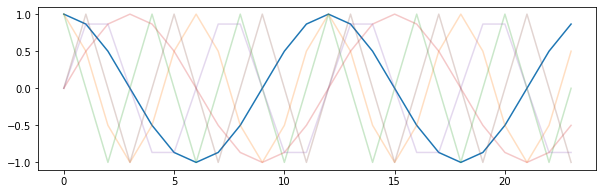

In [29]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(monthly_x[:p*2, 0])
ax.plot(monthly_x[:p*2, 1:], alpha=.25)

plt.savefig("../plots/fig7_fourier_basis.png")

#### GAM

In [30]:
n_changepoints = 12

In [31]:
# See time_series_tfp_linear.ipynb for detail of what the following code does:
co2_by_month = pd.read_csv("../data/monthly_mauna_loa_co2_20220721.csv", comment='#')
co2_by_month['year_string'] = co2_by_month['year'].astype(str)
co2_by_month['month_string'] = co2_by_month['month'].astype(str)
co2_by_month['date_month'] = pd.to_datetime(co2_by_month['year_string'] + '/' + co2_by_month['month_string'])
co2_by_month.set_index('date_month', drop=True, inplace=True)
co2_by_month.drop(columns=['year', 'month', 'year_string', 'month_string'], inplace=True)
co2_by_month['CO2'] = co2_by_month['average'].astype(np.float32)
co2_by_month.drop(columns=['decimal date', 'average', 'deseasonalized', 'ndays', 'sdev', 'unc'], inplace=True)

In [32]:
co2_by_month

,CO2
date_month,
1958-03-01,315.700012
1958-04-01,317.450012
1958-05-01,317.510010
1958-06-01,317.239990
1958-07-01,315.859985
...,...
2022-02-01,419.279999
2022-03-01,418.809998
2022-04-01,420.230011


In [33]:
# See time_series_tfp_linear.ipynb for detail of what the following code does:
num_forecast_steps = 12 * 10 # Forecast the final ten years
co2_by_month_training_data = co2_by_month[:-num_forecast_steps]
co2_by_month_testing_data = co2_by_month[-num_forecast_steps:]

In [34]:
# See time_series_tfp_linear.ipynb for detail of what the following code does:
num_forecast_steps = 12 * 10 # Forecast the final ten years
trend_all = np.linspace(0., 1., len(co2_by_month))[..., None]
trend_all = trend_all.astype(np.float32)
seasonality_all = pd.get_dummies(
   co2_by_month.index.month).values.astype(np.float32)
trend = trend_all[:-num_forecast_steps, :]
seasonality = seasonality_all[:-num_forecast_steps, :]

In [35]:
seasonality_all

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [36]:
n_tp = seasonality_all.shape[0]

In [37]:
n_tp

772

In [38]:
t = np.linspace(0, 1, n_tp, dtype=np.float32)

In [39]:
t

array([0.        , 0.00129702, 0.00259403, 0.00389105, 0.00518807,
       0.00648508, 0.0077821 , 0.00907912, 0.01037613, 0.01167315,
       0.01297017, 0.01426719, 0.0155642 , 0.01686122, 0.01815824,
       0.01945525, 0.02075227, 0.02204929, 0.0233463 , 0.02464332,
       0.02594034, 0.02723735, 0.02853437, 0.02983139, 0.0311284 ,
       0.03242542, 0.03372244, 0.03501945, 0.03631647, 0.03761349,
       0.0389105 , 0.04020752, 0.04150454, 0.04280156, 0.04409857,
       0.04539559, 0.04669261, 0.04798963, 0.04928664, 0.05058366,
       0.05188068, 0.05317769, 0.05447471, 0.05577172, 0.05706874,
       0.05836576, 0.05966277, 0.06095979, 0.06225681, 0.06355383,
       0.06485084, 0.06614786, 0.06744488, 0.0687419 , 0.07003891,
       0.07133593, 0.07263295, 0.07392996, 0.07522698, 0.076524  ,
       0.07782101, 0.07911803, 0.08041505, 0.08171206, 0.08300908,
       0.0843061 , 0.08560311, 0.08690013, 0.08819715, 0.08949416,
       0.09079118, 0.0920882 , 0.09338521, 0.09468223, 0.09597

In [40]:
s = np.linspace(0, max(t), n_changepoints + 2, dtype=np.float32)[1: -1]

In [41]:
s

array([0.07692308, 0.15384616, 0.23076923, 0.30769232, 0.3846154 ,
       0.46153846, 0.53846157, 0.61538464, 0.6923077 , 0.7692308 ,
       0.84615386, 0.9230769 ], dtype=float32)

In [42]:
matrix_a = (t[:, None] > s).astype(np.float32)

In [43]:
matrix_a

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [44]:
np.where(seasonality_all)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [45]:
np.where(seasonality_all)[0].shape

(772,)

In [46]:
np.where(seasonality_all)[1].shape

(772,)

In [47]:
seasonality_all.shape[-1]

12

In [48]:
seasonality_all.shape

(772, 12)

#### GAM code

##### Generate trend design matrix

In [49]:
n_changepoints = 12

In [50]:
n_tp = seasonality_all.shape[0]

In [51]:
n_tp

772

In [52]:
t = np.linspace(0, 1, n_tp, dtype=np.float32)

In [53]:
t

array([0.        , 0.00129702, 0.00259403, 0.00389105, 0.00518807,
       0.00648508, 0.0077821 , 0.00907912, 0.01037613, 0.01167315,
       0.01297017, 0.01426719, 0.0155642 , 0.01686122, 0.01815824,
       0.01945525, 0.02075227, 0.02204929, 0.0233463 , 0.02464332,
       0.02594034, 0.02723735, 0.02853437, 0.02983139, 0.0311284 ,
       0.03242542, 0.03372244, 0.03501945, 0.03631647, 0.03761349,
       0.0389105 , 0.04020752, 0.04150454, 0.04280156, 0.04409857,
       0.04539559, 0.04669261, 0.04798963, 0.04928664, 0.05058366,
       0.05188068, 0.05317769, 0.05447471, 0.05577172, 0.05706874,
       0.05836576, 0.05966277, 0.06095979, 0.06225681, 0.06355383,
       0.06485084, 0.06614786, 0.06744488, 0.0687419 , 0.07003891,
       0.07133593, 0.07263295, 0.07392996, 0.07522698, 0.076524  ,
       0.07782101, 0.07911803, 0.08041505, 0.08171206, 0.08300908,
       0.0843061 , 0.08560311, 0.08690013, 0.08819715, 0.08949416,
       0.09079118, 0.0920882 , 0.09338521, 0.09468223, 0.09597

In [54]:
max(t)

1.0

In [55]:
s = np.linspace(0, max(t), n_changepoints + 2, dtype=np.float32)[1: -1]

In [56]:
s

array([0.07692308, 0.15384616, 0.23076923, 0.30769232, 0.3846154 ,
       0.46153846, 0.53846157, 0.61538464, 0.6923077 , 0.7692308 ,
       0.84615386, 0.9230769 ], dtype=float32)

In [57]:
matrix_a = (t[:, None] > s).astype(np.float32)

In [58]:
matrix_a

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

##### Generate seasonality design matrix

In [60]:
# %load 'fourier_basis_function.py'
def gen_fourier_basis(t, p=365.25, n=3):
    x = 2 * np.pi * (np.arange(n) + 1) * t[:, None] / p 
    return np.concatenate((np.cos(x), np.sin(x)), axis=1)

In [61]:
x_pred = gen_fourier_basis(np.where(seasonality_all)[1],
                           p=seasonality_all.shape[-1],
                           n=6)

In [63]:
x_pred

array([[ 5.00000000e-01, -5.00000000e-01, -1.00000000e+00, ...,
        -8.66025404e-01, -8.66025404e-01, -2.44929360e-16],
       [ 6.12323400e-17, -1.00000000e+00, -1.83697020e-16, ...,
        -2.44929360e-16,  1.00000000e+00,  3.67394040e-16],
       [-5.00000000e-01, -5.00000000e-01,  1.00000000e+00, ...,
         8.66025404e-01, -8.66025404e-01, -4.89858720e-16],
       ...,
       [ 6.12323400e-17, -1.00000000e+00, -1.83697020e-16, ...,
        -2.44929360e-16,  1.00000000e+00,  3.67394040e-16],
       [-5.00000000e-01, -5.00000000e-01,  1.00000000e+00, ...,
         8.66025404e-01, -8.66025404e-01, -4.89858720e-16],
       [-8.66025404e-01,  5.00000000e-01,  1.19434012e-15, ...,
        -8.66025404e-01,  5.00000000e-01,  2.38868024e-15]])

In [62]:
n_pred = x_pred.shape[-1]

In [64]:
n_pred

12

In [120]:
# %load 'gam_coroutine.py'
import tensorflow as tf
import tensorflow_probability as tfp

def gen_gam_jd(training=True):
    @tfp.distributions.JointDistributionCoroutine
    def gam():
        beta = yield tfp.distributions.JointDistributionCoroutine.Root(
            tfp.distributions.Sample( 
                tfp.distributions.Normal(0., 1.), 
                sample_shape=n_pred, 
                name='beta'))
        seasonality = tf.einsum('ij,...j->...i', x_pred, beta)

        k = yield tfp.distributions.JointDistributionCoroutine.Root(
                tfp.distributions.HalfNormal(10., name='k'))
        m = yield tfp.distributions.JointDistributionCoroutine.Root(
                tfp.distributions.Normal(
                    co2_by_month_training_data['CO2'].mean(), 
                    scale=5., name='m'))
        tau = yield tfp.distributions.JointDistributionCoroutine.Root(
                tfp.distributions.HalfNormal(10., name='tau'))
        delta = yield tfp.distributions.Sample(
                tfp.distributions.Laplace(0., tau),
                    sample_shape=n_changepoints,
                    name='delta')

        growth_rate = k[..., None] + tf.einsum('ij,...j->...i', matrix_a, delta)
        offset = m[..., None] + tf.einsum('ij,...j->...i', matrix_a, -s * delta)
        trend = growth_rate * t + offset

        y_hat = seasonality + trend
        if training:
            y_hat = y_hat[..., :co2_by_month_training_data.shape[0]]

        noise_sigma = yield tfp.distributions.JointDistributionCoroutine.Root(
            tfp.distributions.HalfNormal(scale=5., name='noise_sigma'))
        observed = yield tfp.distributions.Independent(
            tfp.distributions.Normal(y_hat, noise_sigma[..., None]), 
            reinterpreted_batch_ndims=1, name='observed')
        
    return gam

In [157]:
gam = gen_gam_jd()

In [158]:
prior_samples = gam.sample(100)

In [159]:
prior_samples

StructTuple(
  beta=<tf.Tensor: shape=(100, 12), dtype=float32, numpy=
    array([[ 2.524935  , -2.0333166 , -0.41779587, ...,  0.48820078,
            -1.0589011 ,  0.7225459 ],
           [-0.36606222,  0.22396167,  1.1536702 , ..., -0.44161227,
             0.02856848, -1.0916624 ],
           [-0.2751511 , -2.6207616 , -0.74554545, ...,  0.07394904,
            -0.23791163,  0.22591786],
           ...,
           [-0.99148023, -0.0978793 , -2.4434206 , ...,  0.7261815 ,
             1.3354597 , -0.07445572],
           [ 0.32685634, -1.8989323 , -0.19185244, ..., -1.2217594 ,
             0.27939856, -0.9910777 ],
           [-1.3157448 ,  1.2402097 ,  1.4459345 , ...,  0.6341675 ,
            -0.5490069 , -0.38615382]], dtype=float32)>,
  k=<tf.Tensor: shape=(100,), dtype=float32, numpy=
    array([4.01115179e+00, 1.89182740e-02, 6.85105610e+00, 2.93168485e-01,
           9.74209404e+00, 1.20679736e+00, 4.15759945e+00, 6.80166054e+00,
           1.62595921e+01, 2.03752089e+00, 3.

In [160]:
prior_predictive_timeseries = prior_samples[-1]

In [161]:
prior_predictive_timeseries

<tf.Tensor: shape=(100, 652), dtype=float32, numpy=
array([[354.09955, 347.9525 , 349.24405, ..., 364.23642, 365.67505,
        362.89642],
       [336.66852, 331.3187 , 332.14255, ..., 345.8624 , 346.76035,
        347.23724],
       [353.36923, 327.39752, 346.70758, ..., 349.5313 , 332.01273,
        330.8442 ],
       ...,
       [347.3277 , 339.89108, 331.31158, ..., 363.68643, 341.96213,
        350.29346],
       [351.7817 , 344.4493 , 351.3305 , ..., 319.91516, 319.254  ,
        319.9697 ],
       [340.1993 , 323.05515, 349.67136, ..., 385.30673, 345.255  ,
        375.73386]], dtype=float32)>

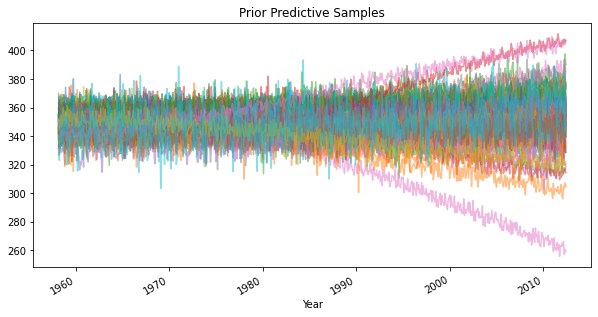

In [162]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(co2_by_month.index[:-num_forecast_steps],
    tf.transpose(prior_predictive_timeseries), alpha=.5)
ax.set_xlabel("Year")
ax.set_title('Prior Predictive Samples')
fig.autofmt_xdate()

plt.savefig("../plots/gam_prior_predictive2.png");

#### Posterior samples

In [163]:
run_mcmc = tf.function(tfp.experimental.mcmc.windowed_adaptive_nuts, autograph=False, jit_compile=True)

In [164]:
%%time
mcmc_samples, sampler_stats = run_mcmc(
    1000, gam, n_chains=4, num_adaptation_steps=1000,
    seed=tf.constant([-12341, 62345], dtype=tf.int32),
    observed=co2_by_month_training_data.T)

2022-07-27 17:44:53.661371: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


CPU times: user 1min 16s, sys: 2.12 s, total: 1min 18s
Wall time: 1min 23s


In [198]:
co2_by_month_training_data.T

date_month,1958-03-01,1958-04-01,1958-05-01,1958-06-01,1958-07-01,1958-08-01,1958-09-01,1958-10-01,1958-11-01,1958-12-01,...,2011-09-01,2011-10-01,2011-11-01,2011-12-01,2012-01-01,2012-02-01,2012-03-01,2012-04-01,2012-05-01,2012-06-01
CO2,315.700012,317.450012,317.51001,317.23999,315.859985,314.929993,313.200012,312.429993,313.329987,314.670013,...,389.279999,389.190002,390.480011,392.059998,393.309998,394.040009,394.589996,396.380005,396.929993,395.910004


In [165]:
mcmc_samples

StructTuple(
  beta=<tf.Tensor: shape=(1000, 4, 12), dtype=float32, numpy=
    array([[[ 1.7343823 ,  0.38054472, -0.19362715, ..., -0.6250266 ,
             -0.71721536,  1.9261638 ],
            [ 0.43410802,  1.6194228 ,  1.9024826 , ..., -0.72221273,
             -0.01387841, -0.24730514],
            [-0.15804107, -0.20025985,  0.25568566, ...,  0.6564799 ,
              1.8668969 ,  1.9214128 ],
            [ 1.7565511 ,  0.7544677 , -0.23468374, ..., -0.71726424,
              0.6842408 ,  0.42881343]],
    
           [[ 1.7343823 ,  0.38054472, -0.19362715, ..., -0.6250266 ,
             -0.71721536,  1.9261638 ],
            [ 0.43410802,  1.6194228 ,  1.9024826 , ..., -0.72221273,
             -0.01387841, -0.24730514],
            [-0.15804107, -0.20025985,  0.25568566, ...,  0.6564799 ,
              1.8668969 ,  1.9214128 ],
            [ 1.7565511 ,  0.7544677 , -0.23468374, ..., -0.71726424,
              0.6842408 ,  0.42881343]],
    
           [[ 1.7343823 ,  0.3805

In [166]:
sampler_stats

{'step_size': <tf.Tensor: shape=(1000,), dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0

In [167]:
gam_idata = az.from_dict(
    posterior={
        k:np.swapaxes(v.numpy(), 1, 0)
        for k, v in mcmc_samples._asdict().items()}, 
    sample_stats={
        k:np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]}
)

In [168]:
gam_idata

Inference data with groups:
	> posterior
	> sample_stats

/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Ver

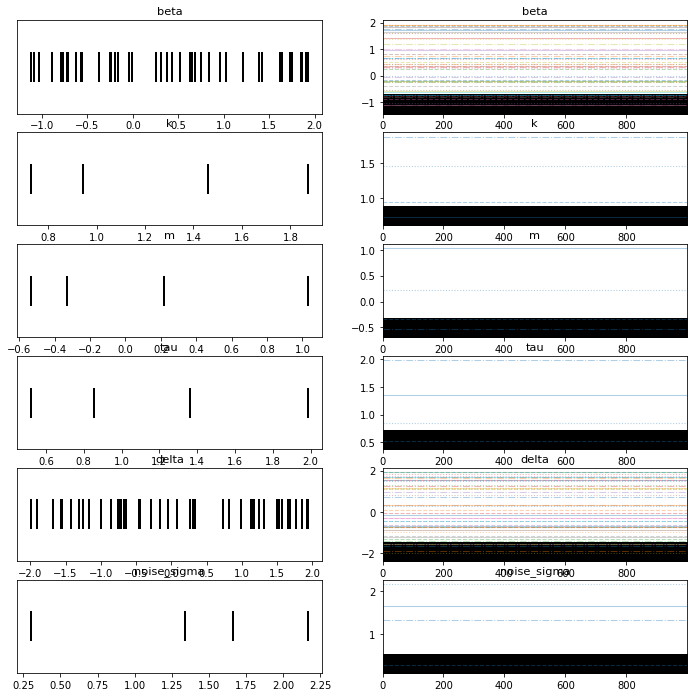

In [169]:
axes = az.plot_trace(gam_idata, compact=True);

In [170]:
gam_full = gen_gam_jd(training=False)

In [171]:
posterior_dists, _ = gam_full.sample_distributions(value=mcmc_samples)

In [172]:
posterior_dists

StructTuple(
  beta=<tfp.distributions.Sample 'beta' batch_shape=[] event_shape=[12] dtype=float32>,
  k=<tfp.distributions.HalfNormal 'k' batch_shape=[] event_shape=[] dtype=float32>,
  m=<tfp.distributions.Normal 'm' batch_shape=[] event_shape=[] dtype=float32>,
  tau=<tfp.distributions.HalfNormal 'tau' batch_shape=[] event_shape=[] dtype=float32>,
  delta=<tfp.distributions.Sample 'delta' batch_shape=[1000, 4] event_shape=[12] dtype=float32>,
  noise_sigma=<tfp.distributions.HalfNormal 'noise_sigma' batch_shape=[] event_shape=[] dtype=float32>,
  observed=<tfp.distributions.Independent 'observed' batch_shape=[1000, 4] event_shape=[772] dtype=float32>
)

In [173]:
k, m, tau, delta = mcmc_samples[1:5]

In [174]:
k

<tf.Tensor: shape=(1000, 4), dtype=float32, numpy=
array([[0.7297027, 1.4590895, 0.9426873, 1.8720357],
       [0.7297027, 1.4590895, 0.9426873, 1.8720357],
       [0.7297027, 1.4590895, 0.9426873, 1.8720357],
       ...,
       [0.7297027, 1.4590895, 0.9426873, 1.8720357],
       [0.7297027, 1.4590895, 0.9426873, 1.8720357],
       [0.7297027, 1.4590895, 0.9426873, 1.8720357]], dtype=float32)>

In [175]:
m

<tf.Tensor: shape=(1000, 4), dtype=float32, numpy=
array([[ 1.0309293 ,  0.22053906, -0.3322573 , -0.5332589 ],
       [ 1.0309293 ,  0.22053906, -0.3322573 , -0.5332589 ],
       [ 1.0309293 ,  0.22053906, -0.3322573 , -0.5332589 ],
       ...,
       [ 1.0309293 ,  0.22053906, -0.3322573 , -0.5332589 ],
       [ 1.0309293 ,  0.22053906, -0.3322573 , -0.5332589 ],
       [ 1.0309293 ,  0.22053906, -0.3322573 , -0.5332589 ]],
      dtype=float32)>

In [176]:
matrix_a

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [177]:
delta

<tf.Tensor: shape=(1000, 4, 12), dtype=float32, numpy=
array([[[-0.6711707 , -0.73531103,  1.9177284 , ...,  1.6861157 ,
         -0.16408059,  0.3117397 ],
        [ 0.2657216 , -0.9989899 ,  1.3093549 , ..., -0.44815153,
          1.4914361 ,  1.1758024 ],
        [-0.4627757 ,  0.08035602, -1.3101937 , ...,  1.5251935 ,
          1.9354693 , -0.75660247],
        [-1.6707594 ,  1.6494247 , -1.4245896 , ..., -0.7169452 ,
          0.73359096, -1.8993284 ]],

       [[-0.6711707 , -0.73531103,  1.9177284 , ...,  1.6861157 ,
         -0.16408059,  0.3117397 ],
        [ 0.2657216 , -0.9989899 ,  1.3093549 , ..., -0.44815153,
          1.4914361 ,  1.1758024 ],
        [-0.4627757 ,  0.08035602, -1.3101937 , ...,  1.5251935 ,
          1.9354693 , -0.75660247],
        [-1.6707594 ,  1.6494247 , -1.4245896 , ..., -0.7169452 ,
          0.73359096, -1.8993284 ]],

       [[-0.6711707 , -0.73531103,  1.9177284 , ...,  1.6861157 ,
         -0.16408059,  0.3117397 ],
        [ 0.2657216 , -

In [178]:
growth_rate = k[..., None] + tf.einsum('ij,...j->...i', matrix_a, delta)

In [179]:
growth_rate

<tf.Tensor: shape=(1000, 4, 772), dtype=float32, numpy=
array([[[0.7297027, 0.7297027, 0.7297027, ..., 1.766187 , 1.766187 ,
         1.766187 ],
        [1.4590895, 1.4590895, 1.4590895, ..., 6.280242 , 6.280242 ,
         6.280242 ],
        [0.9426873, 0.9426873, 0.9426873, ..., 0.1820457, 0.1820457,
         0.1820457],
        [1.8720357, 1.8720357, 1.8720357, ..., 2.7913756, 2.7913756,
         2.7913756]],

       [[0.7297027, 0.7297027, 0.7297027, ..., 1.766187 , 1.766187 ,
         1.766187 ],
        [1.4590895, 1.4590895, 1.4590895, ..., 6.280242 , 6.280242 ,
         6.280242 ],
        [0.9426873, 0.9426873, 0.9426873, ..., 0.1820457, 0.1820457,
         0.1820457],
        [1.8720357, 1.8720357, 1.8720357, ..., 2.7913756, 2.7913756,
         2.7913756]],

       [[0.7297027, 0.7297027, 0.7297027, ..., 1.766187 , 1.766187 ,
         1.766187 ],
        [1.4590895, 1.4590895, 1.4590895, ..., 6.280242 , 6.280242 ,
         6.280242 ],
        [0.9426873, 0.9426873, 0.9426873

In [180]:
offset = m[..., None] + tf.einsum('ij,...j->...i', matrix_a, -s * delta)

In [181]:
offset

<tf.Tensor: shape=(1000, 4, 772), dtype=float32, numpy=
array([[[ 1.0309293 ,  1.0309293 ,  1.0309293 , ..., -0.02289367,
         -0.02289367, -0.02289367],
        [ 0.22053906,  0.22053906,  0.22053906, ..., -1.8547502 ,
         -1.8547502 , -1.8547502 ],
        [-0.3322573 , -0.3322573 , -0.3322573 , ..., -1.4180214 ,
         -1.4180214 , -1.4180214 ],
        [-0.5332589 , -0.5332589 , -0.5332589 , ..., -0.15333939,
         -0.15333939, -0.15333939]],

       [[ 1.0309293 ,  1.0309293 ,  1.0309293 , ..., -0.02289367,
         -0.02289367, -0.02289367],
        [ 0.22053906,  0.22053906,  0.22053906, ..., -1.8547502 ,
         -1.8547502 , -1.8547502 ],
        [-0.3322573 , -0.3322573 , -0.3322573 , ..., -1.4180214 ,
         -1.4180214 , -1.4180214 ],
        [-0.5332589 , -0.5332589 , -0.5332589 , ..., -0.15333939,
         -0.15333939, -0.15333939]],

       [[ 1.0309293 ,  1.0309293 ,  1.0309293 , ..., -0.02289367,
         -0.02289367, -0.02289367],
        [ 0.22053906, 

In [182]:
trend_posterior = growth_rate * t + offset

In [183]:
trend_posterior

<tf.Tensor: shape=(1000, 4, 772), dtype=float32, numpy=
array([[[ 1.0309293 ,  1.0318757 ,  1.0328223 , ...,  1.7387117 ,
          1.7410026 ,  1.7432933 ],
        [ 0.22053906,  0.22243153,  0.22432399, ...,  4.4092007 ,
          4.4173465 ,  4.425492  ],
        [-0.3322573 , -0.33103463, -0.32981193, ..., -1.2364479 ,
         -1.2362119 , -1.2359757 ],
        [-0.5332589 , -0.53083086, -0.5284028 , ...,  2.6307952 ,
          2.6344159 ,  2.6380363 ]],

       [[ 1.0309293 ,  1.0318757 ,  1.0328223 , ...,  1.7387117 ,
          1.7410026 ,  1.7432933 ],
        [ 0.22053906,  0.22243153,  0.22432399, ...,  4.4092007 ,
          4.4173465 ,  4.425492  ],
        [-0.3322573 , -0.33103463, -0.32981193, ..., -1.2364479 ,
         -1.2362119 , -1.2359757 ],
        [-0.5332589 , -0.53083086, -0.5284028 , ...,  2.6307952 ,
          2.6344159 ,  2.6380363 ]],

       [[ 1.0309293 ,  1.0318757 ,  1.0328223 , ...,  1.7387117 ,
          1.7410026 ,  1.7432933 ],
        [ 0.22053906, 

In [184]:
x_pred.shape

(772, 12)

In [185]:
seasonality_posterior = tf.einsum('ij,...j->...i', x_pred, mcmc_samples[0])

In [186]:
seasonality_posterior

<tf.Tensor: shape=(1000, 4, 772), dtype=float32, numpy=
array([[[ 4.1353016 , -2.040482  , -2.8705533 , ..., -2.040482  ,
         -2.8705533 , -5.402398  ],
        [-1.563231  , -1.5393659 , -1.2363396 , ..., -1.5393659 ,
         -1.2363396 ,  0.54189944],
        [-2.1052132 , -0.94778   , -0.02115178, ..., -0.94778   ,
         -0.02115178,  0.6768693 ],
        [-0.32677436,  1.1728714 , -2.3887782 , ...,  1.1728714 ,
         -2.3887782 ,  3.1593463 ]],

       [[ 4.1353016 , -2.040482  , -2.8705533 , ..., -2.040482  ,
         -2.8705533 , -5.402398  ],
        [-1.563231  , -1.5393659 , -1.2363396 , ..., -1.5393659 ,
         -1.2363396 ,  0.54189944],
        [-2.1052132 , -0.94778   , -0.02115178, ..., -0.94778   ,
         -0.02115178,  0.6768693 ],
        [-0.32677436,  1.1728714 , -2.3887782 , ...,  1.1728714 ,
         -2.3887782 ,  3.1593463 ]],

       [[ 4.1353016 , -2.040482  , -2.8705533 , ..., -2.040482  ,
         -2.8705533 , -5.402398  ],
        [-1.563231  , 

In [187]:
nchains = gam_idata.posterior.dims['chain']

In [188]:
nchains

4

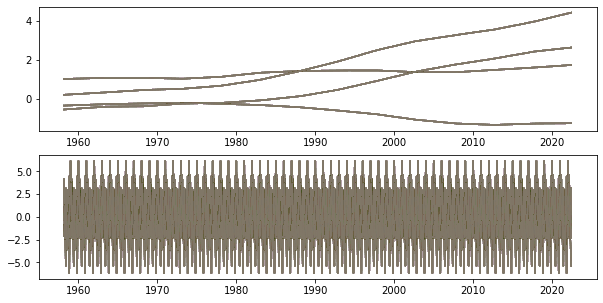

In [189]:
_, ax = plt.subplots(2, 1, figsize=(10, 5))
for i in range(nchains): 
    ax[0].plot(co2_by_month.index,
               trend_posterior[-100:, i, :].numpy().T, alpha=.05)
    ax[1].plot(co2_by_month.index,
               seasonality_posterior[-100:, i, :].numpy().T, alpha=.05)

In [190]:
fitted_with_forecast = posterior_dists[-1].distribution.sample().numpy()

In [191]:
fitted_with_forecast

array([[[ 5.438947  , -1.4585781 ,  1.2822558 , ..., -0.08087666,
         -0.5311683 , -6.1680055 ],
        [-2.7104235 ,  5.204382  , -3.278513  , ...,  2.0391512 ,
          3.417445  ,  2.826019  ],
        [-1.8434354 , -1.5391831 , -0.05627704, ..., -2.7842638 ,
         -0.9735044 , -1.188704  ],
        [-1.2312052 ,  2.5897253 , -2.8329182 , ...,  2.585407  ,
          1.0689781 ,  6.1498775 ]],

       [[ 5.8467164 , -0.41158324, -0.4604336 , ..., -0.87502235,
          0.74913824, -3.5360162 ],
        [ 0.44219458, -1.4059899 ,  0.2548597 , ...,  2.1765752 ,
          1.1039829 ,  5.105958  ],
        [-2.406941  , -1.509844  , -0.8398266 , ..., -2.3632119 ,
         -1.074804  , -0.9036385 ],
        [-0.4994105 ,  0.5454705 , -3.0203712 , ...,  2.6231496 ,
          0.56287277,  6.4559817 ]],

       [[ 4.4433274 ,  0.48695612, -2.8869348 , ...,  1.9506227 ,
         -1.9362779 , -6.8724375 ],
        [ 1.55163   , -6.168668  ,  3.067187  , ...,  3.26499   ,
         -1.

In [192]:
fitted_with_forecast.shape

(1000, 4, 772)

In [193]:
average_forecast = np.mean(fitted_with_forecast, axis=(0, 1)).T

In [194]:
average_forecast

array([ 1.22705869e-01, -7.55880952e-01, -1.53015816e+00, -1.38015240e-01,
       -7.92873800e-02, -1.46785152e+00,  1.09671938e+00, -2.61630826e-02,
       -2.84751207e-01, -2.00096875e-01,  2.86642432e+00,  1.66508341e+00,
        1.45575508e-01, -7.08432317e-01, -1.51181757e+00, -9.77478176e-02,
       -5.95282065e-03, -1.40968966e+00,  1.10144126e+00, -6.94199372e-03,
       -3.27220768e-01, -1.99901447e-01,  2.81193185e+00,  1.68481481e+00,
        1.55695289e-01, -7.39520609e-01, -1.48385274e+00, -8.51959810e-02,
       -5.20758331e-05, -1.38942671e+00,  1.10288763e+00,  5.94875310e-04,
       -2.77606130e-01, -1.76556885e-01,  2.87759423e+00,  1.71509445e+00,
        2.11513758e-01, -6.88604593e-01, -1.49127316e+00, -1.03246614e-01,
       -2.48137023e-03, -1.38318229e+00,  1.10975373e+00,  1.81987472e-02,
       -2.35434413e-01, -1.53006449e-01,  2.88319016e+00,  1.69715238e+00,
        2.20666096e-01, -6.27181351e-01, -1.41553938e+00, -1.07458740e-01,
        4.79439981e-02, -

In [195]:
average_forecast.shape

(772,)

In [151]:
# %load 'plot_co2_data.py'
def plot_co2_data(fig_ax=None):
    if not fig_ax:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    else:
        fig, ax = fig_ax
    ax.plot(co2_by_month_training_data, label="training data")
    ax.plot(co2_by_month_testing_data, color="C4", label="testing data")
    ax.legend()
    ax.set(
        ylabel="Atmospheric CO2 concentration (ppm)",
        xlabel="Year"
    )
    ax.text(0.99, .02,
              """Source: National Oceanic & Atmospheric Administraion 
                         Trends in Atmospheric Carbon Dioxide
              https://gml.noaa.gov/ccgg/trends/data.html""",
              transform=ax.transAxes,
              horizontalalignment="right",
              alpha=0.5)
    fig.autofmt_xdate()
    return fig, ax

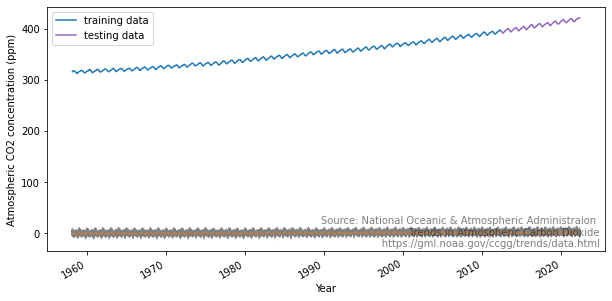

In [196]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(co2_by_month.index, fitted_with_forecast[-100:, 0, :].T, color='gray',
alpha=.1);
ax.plot(co2_by_month.index, fitted_with_forecast[-100:, 1, :].T, color='gray',
alpha=.1);

plot_co2_data((fig, ax));

ax.plot(co2_by_month.index, average_forecast, ls='--', label='GAM forecast',
alpha=.5);

### Didn't work well. mcmc_samples values are wrong. TODO: Investigate.

Text(0.5, 1.0, '$\\sigma_{noise}$ (Normal)')

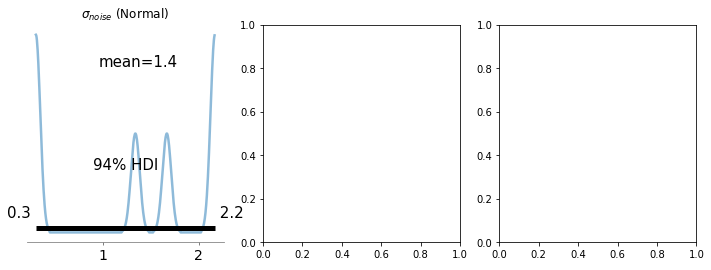

In [199]:
fig, axes = plt.subplots(1, 3, figsize=(4*3, 4))
az.plot_posterior(gam_idata, var_names=['noise_sigma'], alpha=.5, lw=2.5, ax=axes[0]);
axes[0].set_title(r'$\sigma_{noise}$ (Normal)')